## Project #2 - No Show Appointments

## Questions we want to answer in the end

### General question
* Which characteristics determine that a patient will not appear?

### Intermediate questions
* Q1. Do the patients' age or gender influence their no-show?
* Q2. Are there days of the week of scheduled appointments that are most likely to no-show patients?
* Q3. Patients with any disease are more likely not to show up?
* Q4. Are there more no-shows patients in the beginning (Days between 1 to 10), middle (days between 10 to 20) or end of the month (days between 21 to 31)?
* Q5. Does the patient's scholarship receipt influence his absence?
* Q6. The reception of SMS helps patients to show up in their appointments?
* Q7. Is the interval between schedule day and appointment day influences no-shows?
* Q8. Are there frequent no show patients? If so, which characteristics do they have?




### 1. Data exploration in order to find dispensable columns and missing data

In [78]:
# Importing Modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Importing data
df = pd.read_csv('data/noshowappointments-kagglev2-may-2016.csv')

# Ensuring that all columns will be lowercase
df.rename(columns=lambda x: x.lower(), inplace=True)

# Getting some data overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patientid         110527 non-null float64
appointmentid     110527 non-null int64
gender            110527 non-null object
scheduledday      110527 non-null object
appointmentday    110527 non-null object
age               110527 non-null int64
neighbourhood     110527 non-null object
scholarship       110527 non-null int64
hipertension      110527 non-null int64
diabetes          110527 non-null int64
alcoholism        110527 non-null int64
handcap           110527 non-null int64
sms_received      110527 non-null int64
no-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [79]:
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


After *info()*, it is possible to know the number of samples (110527) and features (14) as well each feature data type

In [80]:
# Checking the number of unique values
df.nunique()

patientid          62299
appointmentid     110527
gender                 2
scheduledday      103549
appointmentday        27
age                  104
neighbourhood         81
scholarship            2
hipertension           2
diabetes               2
alcoholism             2
handcap                5
sms_received           2
no-show                2
dtype: int64

### 2. Data cleaning and transformation
As appointmentid feature is exclusive to each record (same number of entries and total samples), it can be droped. At a first glance, it seems that patientid could be removed once is a very specific value, but in a furder analysis it is possible to see that the number of unique values in patient id is less the total samples. It indicates that there are patients with more than one appointment. Hence, It is possible to identify those patients that have more no show appointments.

In [81]:
# Removing appointmentid
df.drop(['appointmentid'], axis=1, inplace=True)
df.nunique()

patientid          62299
gender                 2
scheduledday      103549
appointmentday        27
age                  104
neighbourhood         81
scholarship            2
hipertension           2
diabetes               2
alcoholism             2
handcap                5
sms_received           2
no-show                2
dtype: int64

In [82]:
# Checking whether there are inconsistent data like:
# age < 0
df.drop(df.query('age < 0').index, inplace=True)
# appointmentday before scheduledday
df.drop(df.query('appointmentday < scheduledday').index, inplace=True)

If there are duplicates, they can be removed

In [83]:
# Checking duplicates
df.duplicated().sum()
# Droping duplicates
df.drop_duplicates(inplace=True)

Checking if there are null values

In [84]:
# Checking if there are null values
df.isnull().sum()

patientid         0
gender            0
scheduledday      0
appointmentday    0
age               0
neighbourhood     0
scholarship       0
hipertension      0
diabetes          0
alcoholism        0
handcap           0
sms_received      0
no-show           0
dtype: int64

It was decided to create two columns to keep the weekday of schedule and appointment respectively. It was considered important to check if some specifics weekdays have more no show occurrencies. 

Besides, It was decided to create other two columns to check if the schedule and appointment were made in the beginning (days between 1 and 10), middle (days between 11 and 20) or in the end of the month (days between 21 and 31). That was decided in order to check if there is any correlation between the period of the month and the amount of no shows.

In order to create those four columns, two functions were created. The first one *getMonthPeriodFromDate* [i] receives the date value as a string, once 'scheduledday' and 'appointmentday' has string values in original dataset, [ii] converts date value to DateTime and gets the day value. After that [iii] returns the period (beginning, middle or end).

The second function *getWeekDayFromDate()* receives the weekday as number end returns it as a string ('Monday' to 'Sunday')

Both functions were used to all items from 'scheduledday' and 'appointmentday' with 'map'. It was noticied that map function has a bad performance. Maybe there are alternatives to obtain the same result.

In [85]:
# Function that returns if a data is from beginning (1-10), middle (11-20) or end (20-31) of the month
def get_month_period_from_date(date_str):
    if pd.to_datetime(date_str).day <= 10:
        return "beginning"
    elif pd.to_datetime(date_str).day > 10 and pd.to_datetime(date_str).day <= 20:
        return "middle"
    else:
        return "end"

In [86]:
# Function that returns the name of weekday
def get_week_day_from_date(date_str):
    switcher = {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday"
    }
    return switcher.get(pd.to_datetime(date_str).weekday())

In [87]:
# Function that returns the Age Range from age
# The age range considered is:
#    Baby  -> [0,3]
#    Child -> [4, 12]
#    Teenager -> [13, 19]
#    Adult -> [20, 60]
#    Old -> [61, ...]
def get_age_range(age):
    if age >= 0 and age <= 3:
        return 'Baby'
    elif age >= 4 and age <=12:
        return 'Child'
    elif age >= 13 and age <= 19:
        return 'Teenager'
    elif age >= 20 and age <= 60:
        return 'Adult'
    else:
        return 'Old'

In [88]:
# Creating five new columns (age_range and two to get weekday and period of the month to scheduled day and two to appointment day)
# Each element of columns 'scheduledday' and 'appointmentday' is passed to the functions getMonthPeriodFromDate and getWeekDayFromDate by map 
# bad performance here :(
df['age_range'] = df['age'].map(get_age_range)

df['scheduled_weekday'] = df['scheduledday'].map(get_week_day_from_date)
df['schedule_period_of_month'] = df['scheduledday'].map(get_month_period_from_date)

df['appointment_weekday']     = df['appointmentday'].map(get_week_day_from_date)
df['appointment_period_of_month'] = df['appointmentday'].map(get_month_period_from_date)

df.head()

,patientid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,age_range,scheduled_weekday,schedule_period_of_month,appointment_weekday,appointment_period_of_month
5,9.598513e+13,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No,Old,Wednesday,end,Friday,end
6,7.336882e+14,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes,Adult,Wednesday,end,Friday,end
7,3.449833e+12,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes,Adult,Wednesday,end,Friday,end
9,7.812456e+13,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No,Teenager,Wednesday,end,Friday,end
10,7.345362e+14,F,2016-04-27T14:58:11Z,2016-04-29T00:00:00Z,30,NOVA PALESTINA,0,0,0,0,0,0,No,Adult,Wednesday,end,Friday,end


In [89]:
# Creating a new column to store the amount of days (interval) between scheduled date and appointment date
df['days_between_sched_appoint'] = (pd.to_datetime(df['appointmentday']) - pd.to_datetime(df['scheduledday'])).dt.days

In [140]:
# Creating a new column to sumarize if patient has any disease (hipertension, diabetes, alcoholism, handcap)
df['has_disease'] = (df['hipertension'].apply(int) + df['diabetes'].apply(int) + df['alcoholism'].apply(int) + df['handcap'].apply(int)) > 0

In [139]:
df.head(10)

,patientid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,age_range,scheduled_weekday,schedule_period_of_month,appointment_weekday,appointment_period_of_month,days_between_sched_appoint,has_disease
5,9.598513e+13,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No,Old,Wednesday,end,Friday,end,1,True
6,7.336882e+14,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes,Adult,Wednesday,end,Friday,end,1,False
7,3.449833e+12,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes,Adult,Wednesday,end,Friday,end,1,False
9,7.812456e+13,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No,Teenager,Wednesday,end,Friday,end,1,False
10,7.345362e+14,F,2016-04-27T14:58:11Z,2016-04-29T00:00:00Z,30,NOVA PALESTINA,0,0,0,0,0,0,No,Adult,Wednesday,end,Friday,end,1,False
11,7.542951e+12,M,2016-04-26T08:44:12Z,2016-04-29T00:00:00Z,29,NOVA PALESTINA,0,0,0,0,0,1,Yes,Adult,Tuesday,end,Friday,end,2,False
12,5.666548e+14,F,2016-04-28T11:33:51Z,2016-04-29T00:00:00Z,22,NOVA PALESTINA,1,0,0,0,0,0,No,Adult,Thursday,end,Friday,end,0,False
13,9.113946e+14,M,2016-04-28T14:52:07Z,2016-04-29T00:00:00Z,28,NOVA PALESTINA,0,0,0,0,0,0,No,Adult,Thursday,end,Friday,end,0,False
14,9.988472e+13,F,2016-04-28T10:06:24Z,2016-04-29T00:00:00Z,54,NOVA PALESTINA,0,0,0,0,0,0,No,Adult,Thursday,end,Friday,end,0,False
15,9.994839e+10,F,2016-04-26T08:47:27Z,2016-04-29T00:00:00Z,15,NOVA PALESTINA,0,0,0,0,0,1,No,Teenager,Tuesday,end,Friday,end,2,False


## 3. Exploring with visuals to answer some questions

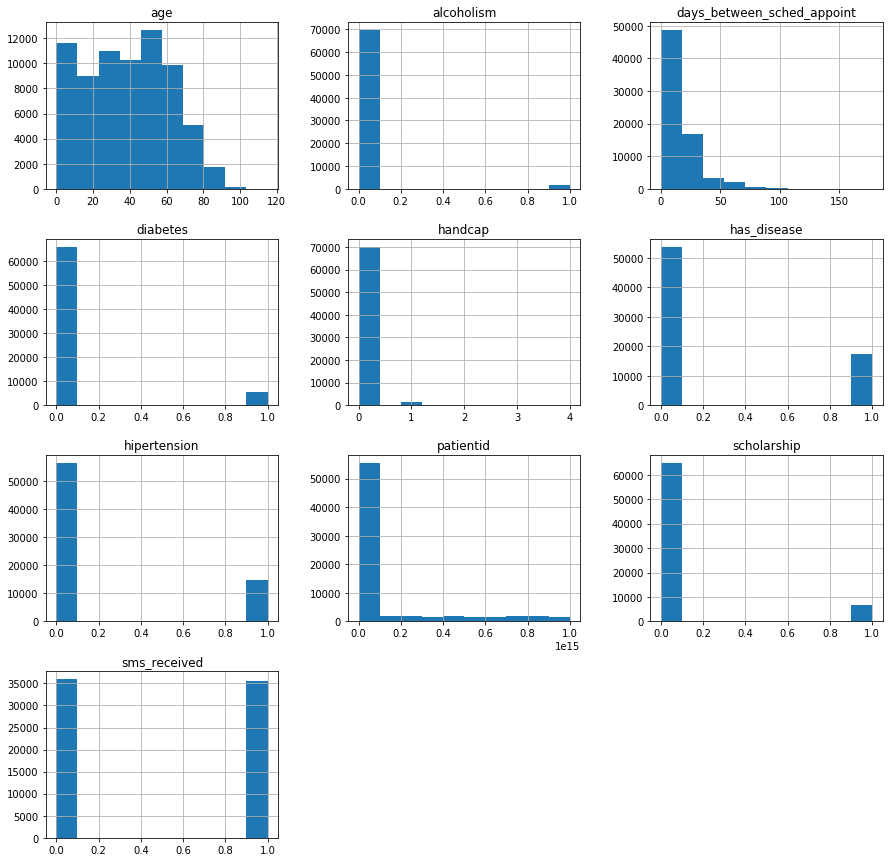

In [141]:
#Getting some view of data distribution
df.hist(figsize = (15,15));

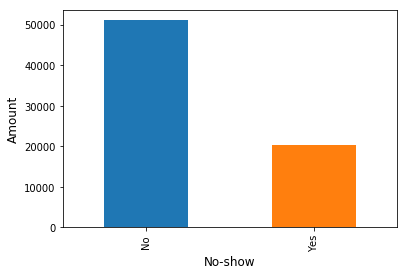

In [154]:
#Let's check how no-show is distributed
ax = df.groupby('no-show').size().plot.bar();
ax.set_xlabel("No-show", fontsize=12)
ax.set_ylabel("Amount", fontsize=12)
plt.show();

In [143]:
df.groupby('no-show').size()

no-show
No     51092
Yes    20317
dtype: int64

The amount of no-show patients is about 28% of total samples.
Now let's detail some variables in order to check how are their distributions and try to infer some observations.

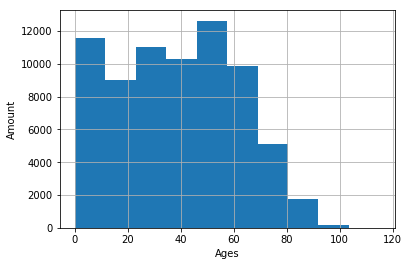

In [144]:
# Let's check Ages distribution
ax = df.age.hist();
ax.set_xlabel("Ages")
ax.set_ylabel("Amount");

It seems that many of the samples are in the age of Adults. Let's confirm it using Age Range variable created in the previous phase.

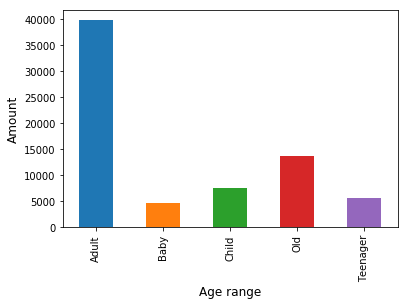

In [95]:
# Let's check Age Range distribution
ax = df.groupby('age_range').size().plot.bar();
ax.set_xlabel("Age range", fontsize=12)
ax.set_ylabel("Amount", fontsize=12)
plt.show();

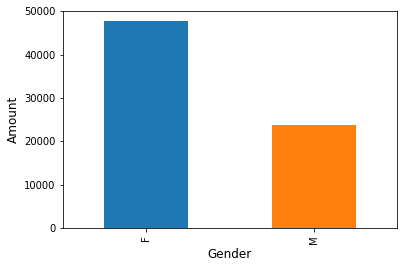

In [151]:
# Let's check gender distribution
ax = df.groupby('gender').size().plot.bar();
ax.set_xlabel("Gender", fontsize=12)
ax.set_ylabel("Amount", fontsize=12)
plt.show();

We can observe that many of the samples are Women

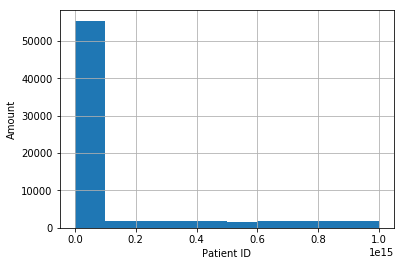

In [96]:
# Let's check patientid distribution 
ax = df.patientid.hist();
ax.set_xlabel("Patient ID")
ax.set_ylabel("Amount")
plt.show()

It's interesting to observe the patient has many repetitions. Let's take a look closer to that variable.

In [152]:
# We can confirm this looking to some value counts
df.patientid.value_counts()

1.484143e+12    30
3.235148e+10    20
3.889955e+13    20
1.779894e+13    20
3.799434e+13    19
5.794481e+11    19
6.285945e+12    19
5.482847e+14    17
2.834654e+13    17
8.632666e+14    17
8.347981e+11    17
6.733238e+13    16
2.162252e+11    16
2.658824e+13    16
1.914297e+14    16
4.967774e+11    15
8.137262e+13    15
8.499856e+14    15
8.569150e+14    15
6.895450e+13    15
7.675349e+13    14
2.723732e+13    14
9.924258e+12    14
2.336589e+14    14
6.233925e+11    14
2.728422e+12    14
7.876974e+14    14
2.642797e+13    14
2.596934e+13    14
4.731615e+13    14
                ..
8.155293e+12     1
2.969536e+12     1
2.733725e+14     1
9.336423e+13     1
4.789364e+14     1
5.242553e+13     1
3.818454e+13     1
2.374734e+13     1
1.148249e+12     1
4.452663e+11     1
6.454414e+13     1
1.446156e+12     1
2.441237e+11     1
8.459194e+14     1
8.559664e+12     1
3.373644e+12     1
9.532928e+13     1
6.532945e+10     1
8.328515e+13     1
9.669387e+13     1
1.274482e+12     1
1.724927e+12

In [98]:
df.patientid.describe()

count    7.140900e+04
mean     1.451792e+14
std      2.534697e+14
min      3.921784e+04
25%      3.967334e+12
50%      2.987795e+13
75%      9.373395e+13
max      9.999320e+14
Name: patientid, dtype: float64

Let's filter those patients who have more than 10 appointments

In [99]:
freq_patients = df.groupby("patientid").filter(lambda x: len(x) > 10)

In [100]:
freq_patients.patientid.value_counts()

1.484143e+12    30
3.235148e+10    20
1.779894e+13    20
3.889955e+13    20
3.799434e+13    19
6.285945e+12    19
5.794481e+11    19
8.632666e+14    17
5.482847e+14    17
2.834654e+13    17
8.347981e+11    17
1.914297e+14    16
2.162252e+11    16
6.733238e+13    16
2.658824e+13    16
8.569150e+14    15
8.499856e+14    15
8.137262e+13    15
6.895450e+13    15
4.967774e+11    15
4.731615e+13    14
5.729433e+13    14
2.336589e+14    14
9.924258e+12    14
7.675349e+13    14
2.616696e+12    14
2.728422e+12    14
2.596934e+13    14
2.642797e+13    14
6.233925e+11    14
                ..
2.649822e+12    12
3.254836e+12    11
1.262168e+13    11
4.694222e+13    11
1.447997e+13    11
4.768616e+11    11
7.333555e+09    11
8.136219e+13    11
6.555919e+13    11
9.349361e+12    11
2.154446e+13    11
4.398649e+12    11
2.681585e+13    11
1.347663e+12    11
2.948428e+14    11
2.213979e+12    11
7.751915e+12    11
5.898937e+11    11
5.323769e+10    11
1.964539e+13    11
7.316670e+13    11
7.224546e+14

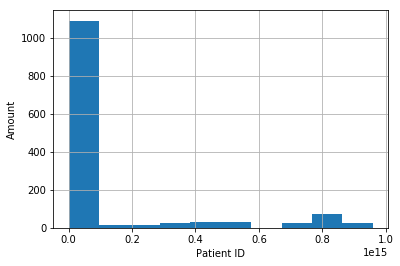

In [155]:
ax = freq_patients.patientid.hist();
ax.set_xlabel("Patient ID")
ax.set_ylabel("Amount")
plt.show()

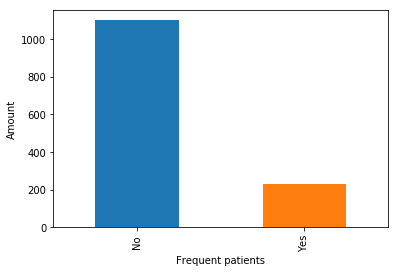

In [157]:
ax = freq_patients.groupby('no-show').size().plot.bar();
ax.set_xlabel("Frequent patients")
ax.set_ylabel("Amount")
plt.show()

In [125]:
freq_patients.groupby('no-show').size()

no-show
No     1099
Yes     229
dtype: int64

Even the frequent patients have a great proportion of showing up (83% against 17% of no-show).

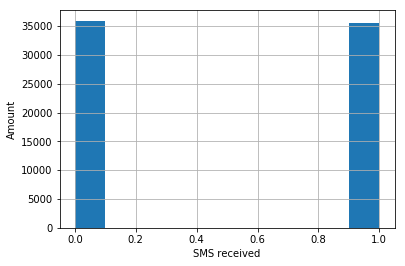

In [159]:
# Let's check how sms_received distribution
ax = df['sms_received'].hist();
ax.set_xlabel("SMS received")
ax.set_ylabel("Amount")
plt.show()

In [147]:
df['sms_received'].value_counts()

0    35927
1    35482
Name: sms_received, dtype: int64

The distribution between those who received and those how didn't is almost the same.

Now let's check how is the distribution of has_disease in all samples

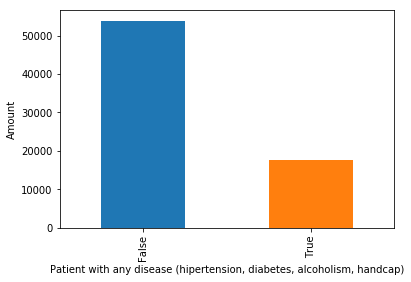

In [161]:
ax = df.groupby('has_disease').size().plot.bar();
ax.set_xlabel("Patient with any disease (hipertension, diabetes, alcoholism, handcap)")
ax.set_ylabel("Amount")
plt.show()

## Limitations

 * I think the amount of data was not a limitation
 * I tried to find some correlation between neighbourhood and no-show frequency, but the neigbourhood distribution is huge and I couldn't find a good way to filter only the relevant data to this analysis
 * The repetition of patientid in most of the samples could be used to identify a pattern of 

# Answering the questions


### Q1. Do the patients' age or gender influence their no-show?

 * In order to answer the question 1, let's check the data behavior about gender and age against no-shows

In [103]:
df.groupby(['gender', 'no-show']).size()

gender  no-show
F       No         34160
        Yes        13544
M       No         16932
        Yes         6773
dtype: int64

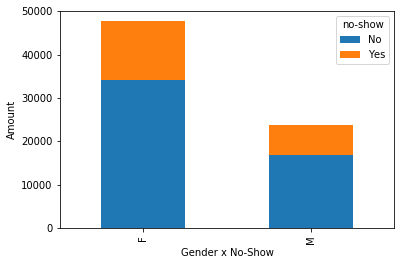

In [163]:
ax = df.groupby(['gender', 'no-show']).size().unstack().plot(kind='bar',stacked=True);
ax.set_xlabel("Gender x No-Show")
ax.set_ylabel("Amount")
plt.show()

In [105]:
df.groupby(['age_range', 'no-show']).size()

age_range  no-show
Adult      No         28099
           Yes        11671
Baby       No          3269
           Yes         1458
Child      No          5215
           Yes         2338
Old        No         10966
           Yes         2805
Teenager   No          3543
           Yes         2045
dtype: int64

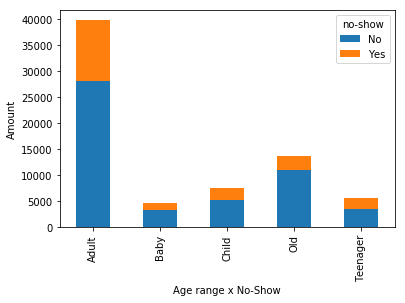

In [164]:
ax = df.groupby(['age_range', 'no-show']).size().unstack().plot(kind='bar',stacked=True);
ax.set_xlabel("Age range x No-Show")
ax.set_ylabel("Amount")
plt.show()

### Q1 Answer

* According to the graphs and data, the gender can not determine a tendency to no-show once both 'F' and 'M' have a very close no-show frequency (About 28%)]

* According to the graphs and data, the age range Teenager has about 37% of no-show frequency. Baby and Child have about 30%. Those three types could be considered more likely not to show up.

### Q2. Are there days of the week of scheduled appointments that are most likely to no-show patients?

The next question tries to infer if there is any correlation between the week days of schedule and appointments. Maybe because there are some influence factors that no-show might be increased in some week days. 

In [107]:
df.groupby(['scheduled_weekday', 'no-show']).size()

scheduled_weekday  no-show
Friday             No          8839
                   Yes         3474
Monday             No         10598
                   Yes         4229
Saturday           No            14
                   Yes            1
Thursday           No          8633
                   Yes         3405
Tuesday            No         12057
                   Yes         4832
Wednesday          No         10951
                   Yes         4376
dtype: int64

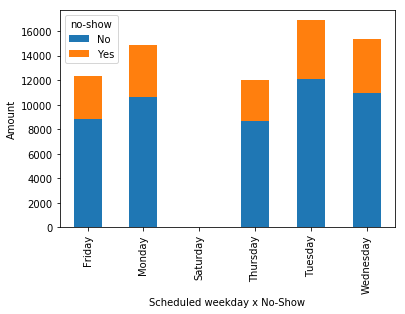

In [167]:
ax = df.groupby(['scheduled_weekday', 'no-show']).size().unstack().plot(kind='bar',stacked=True);
ax.set_xlabel("Scheduled weekday x No-Show")
ax.set_ylabel("Amount")
plt.show()

In [168]:
df.groupby(['appointment_weekday', 'no-show']).size()

appointment_weekday  no-show
Friday               No          8746
                     Yes         3631
Monday               No         10097
                     Yes         4351
Saturday             No            22
                     Yes            9
Thursday             No          8201
                     Yes         3063
Tuesday              No         11679
                     Yes         4672
Wednesday            No         12347
                     Yes         4591
dtype: int64

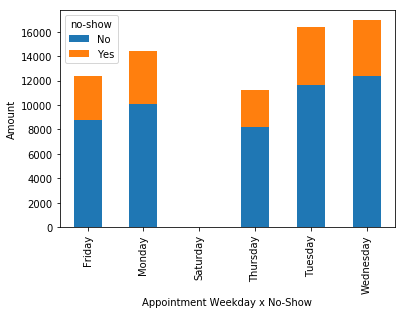

In [169]:
ax = df.groupby(['appointment_weekday', 'no-show']).size().unstack().plot(kind='bar',stacked=True);
ax.set_xlabel("Appointment Weekday x No-Show")
ax.set_ylabel("Amount")
plt.show()

### Q2 Answer
As we can see in both previous graphs there is no correlation between week day in which the schedule was made or the appointment was made. The proportion of no-show is almost the same among all week days (29%).

### Q3. Patients with any disease are more likely not to show up?

Let's check if patients with disease (hipertension, diabetes, alcoholism, handcap) have more no-show frequency.

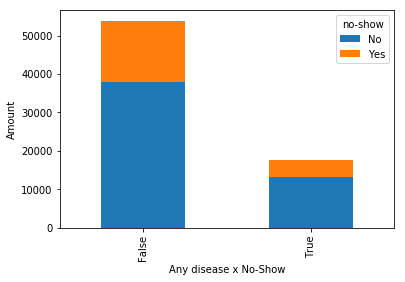

In [170]:
# First any disease (hipertension, diabetes, alcoholism, handcap)
ax = df.groupby(['has_disease', 'no-show']).size().unstack().plot(kind='bar',stacked=True);
ax.set_xlabel("Any disease x No-Show")
ax.set_ylabel("Amount")
plt.show()

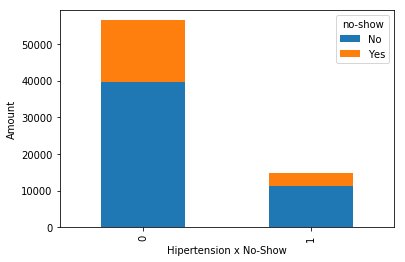

In [171]:
# Hipertension
ax = df.groupby(['hipertension', 'no-show']).size().unstack().plot(kind='bar',stacked=True);
ax.set_xlabel("Hipertension x No-Show")
ax.set_ylabel("Amount")
plt.show()

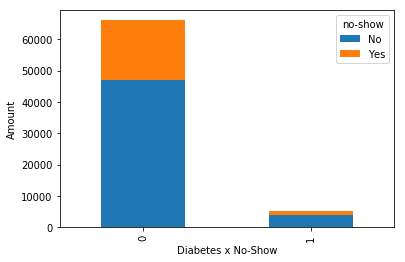

In [172]:
# Diabetes
ax = df.groupby(['diabetes', 'no-show']).size().unstack().plot(kind='bar',stacked=True);
ax.set_xlabel("Diabetes x No-Show")
ax.set_ylabel("Amount")
plt.show()

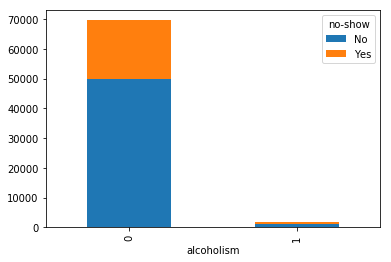

In [173]:
# Alcoholism
df.groupby(['alcoholism', 'no-show']).size().unstack().plot(kind='bar',stacked=True);
ax.set_xlabel("Alcoholism x No-Show")
ax.set_ylabel("Amount")
plt.show()

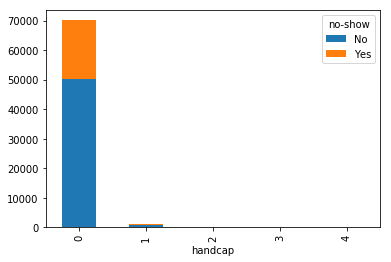

In [174]:
# Handcap                
df.groupby(['handcap', 'no-show']).size().unstack().plot(kind='bar',stacked=True);
ax.set_xlabel("Handcap x No-Show")
ax.set_ylabel("Amount")
plt.show()

### Q3. Answer

As we can see in previous graphs the proportion of no-show patients with disease is less than in patients with no diseases. So, we can conclude that having some of those health limitations is not a factor to no showing up.

### Q4. Are there more no-shows patients in the beginning (Days between 1 to 10), middle (days between 10 to 20) or end of the month (days between 21 to 31)?

This questions tries to identify if there is a correlation of no-shows and the period of the appointment in the month (Beginning, Middle or End)

In [115]:
df.groupby(['appointment_period_of_month', 'no-show']).size()

appointment_period_of_month  no-show
beginning                    No         26146
                             Yes        10141
end                          No          9227
                             Yes         3570
middle                       No         15719
                             Yes         6606
dtype: int64

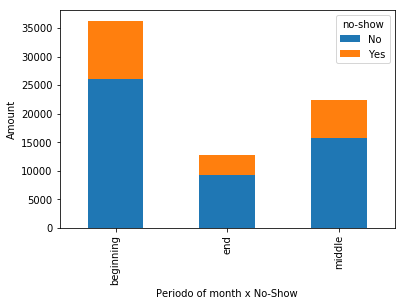

In [175]:
ax = df.groupby(['appointment_period_of_month', 'no-show']).size().unstack().plot(kind='bar',stacked=True);
ax.set_xlabel("Periodo of month x No-Show")
ax.set_ylabel("Amount")
plt.show()

### Q4 Answer

We can observe that the period of the month does not determine the increase of no-shows. All the three periods have similar occurrence of no-shows (About 30%)

### Q5. Does the patient's scholarship receipt influence his absence?

In order to answer this question, let's check the correlation between no-shows and scholarship.

In [117]:
df.groupby(['scholarship', 'no-show']).size()

scholarship  no-show
0            No         46785
             Yes        18005
1            No          4307
             Yes         2312
dtype: int64

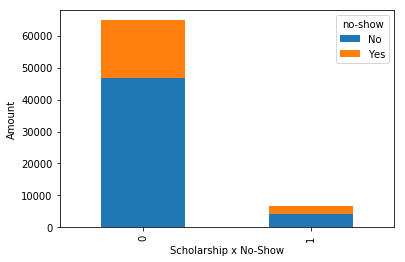

In [177]:
ax = df.groupby(['scholarship', 'no-show']).size().unstack().plot(kind='bar',stacked=True);
ax.set_xlabel("Scholarship x No-Show")
ax.set_ylabel("Amount")
plt.show()

### Q5 Answer

Analysing the previous data (Scholarship X No-Show) we can observe that the amount of patients that receives scholarship is less than the amount of patients who don't. Despite of it, the proportion of those don't show up is greather in patient group who receives scholarship, about 35% against 28% who don't receive.

### Q6. The reception of SMS helps patients to show up in their appointments?

Let's check if patients who received SMS shows up more than who don't received.

In [119]:
df.groupby(['sms_received', 'no-show']).size()

sms_received  no-show
0             No         25394
              Yes        10533
1             No         25698
              Yes         9784
dtype: int64

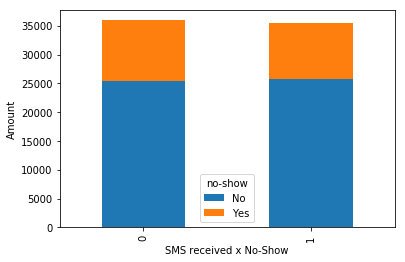

In [178]:
ax = df.groupby(['sms_received', 'no-show']).size().unstack().plot(kind='bar',stacked=True);
ax.set_xlabel("SMS received x No-Show")
ax.set_ylabel("Amount")
plt.show()

### Q6 Answer
By observing the data related to receiving SMS, it is observed that the group of users who receive and the group of those who do not receive have practically the same frequency of no-show. Therefore, we can not deduce that the non-receipt of SMS indicates no-show.

### Q7. Is the interval between schedule day and appointment day influences no-shows?

This question aims to check if the amount of days between schedule and appointment can determine the number of no-shows. This question was thought assuming that the greater interval of days, the greater the number of no-shows.

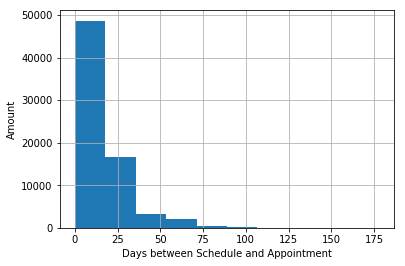

In [179]:
# Initially we will check the distribution of days apart in the dataset.
ax = df['days_between_sched_appoint'].hist();
ax.set_xlabel("Days between Schedule and Appointment")
ax.set_ylabel("Amount")
plt.show()

In [122]:
# As many of the days are concentrated less then 50, it was decided to filter the data frame considering only the 
# interval of 31 days (a month) between schedule and appointment.
df_less31 = df.query('days_between_sched_appoint <= 31')
df_less31.groupby(['days_between_sched_appoint', 'no-show']).size()

days_between_sched_appoint  no-show
0                           No         4063
                            Yes        1099
1                           No         5103
                            Yes        1595
2                           No         2076
                            Yes         635
3                           No         4046
                            Yes        1223
4                           No         2402
                            Yes         862
5                           No         3016
                            Yes         999
6                           No         3563
                            Yes        1299
7                           No         1644
                            Yes         666
8                           No         1159
                            Yes         436
9                           No          944
                            Yes         434
10                          No          666
                            Yes         

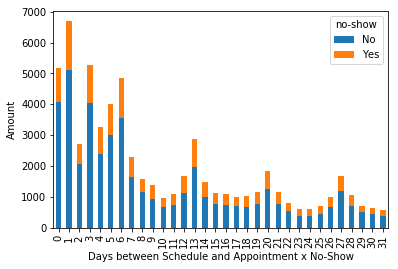

In [180]:
ax = df_less31.groupby(['days_between_sched_appoint', 'no-show']).size().unstack().plot(kind='bar',stacked=True); 
ax.set_xlabel("Days between Schedule and Appointment x No-Show")
ax.set_ylabel("Amount")
plt.show()

### Q7. Answer

When the range of days between scheduling and consultation is less than 10 days the no-show rate is around 25%. From ten days onwards this rate is around 30% and its highest point (40%) when the interval is 24 days. We can conclude that when the consultation date is more than 10 days from the date the appointment was made, the number of no-shows tends to be higher.

### Q8. Are there frequent no show patients? If so, which characteristics do they have?

In [206]:
# Let's get only the no-show frequent patients (those who have more than 10 appointments and didn't show up)
#freq_patients[freq_patients['no-show'] == 'Yes']

,patientid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,age_range,scheduled_weekday,schedule_period_of_month,appointment_weekday,appointment_period_of_month,days_between_sched_appoint
968,7.244332e+14,F,2016-02-26T07:54:45Z,2016-04-29T00:00:00Z,78,CRUZAMENTO,0,1,1,0,0,0,Yes,Old,Friday,end,Friday,end,62
1939,8.499856e+14,M,2016-03-18T14:15:58Z,2016-04-29T00:00:00Z,44,FORTE SÃO JOÃO,0,1,0,1,0,0,Yes,Adult,Friday,middle,Friday,end,41
1940,8.499856e+14,M,2016-03-18T14:15:57Z,2016-04-29T00:00:00Z,44,FORTE SÃO JOÃO,0,1,0,1,0,1,Yes,Adult,Friday,middle,Friday,end,41
2307,5.528716e+11,F,2016-04-12T11:57:15Z,2016-04-29T00:00:00Z,59,BELA VISTA,0,1,0,0,0,1,Yes,Adult,Tuesday,middle,Friday,end,16
2522,2.834654e+13,F,2016-04-27T06:54:30Z,2016-04-29T00:00:00Z,46,ILHA DAS CAIEIRAS,0,1,0,0,0,0,Yes,Adult,Wednesday,end,Friday,end,1
2524,9.274696e+11,F,2016-04-27T06:54:21Z,2016-04-29T00:00:00Z,52,BONFIM,0,1,0,0,0,0,Yes,Adult,Wednesday,end,Friday,end,1
2804,7.675349e+13,F,2016-04-27T11:28:08Z,2016-04-29T00:00:00Z,38,GURIGICA,1,0,0,0,0,0,Yes,Adult,Wednesday,end,Friday,end,1
4314,7.675349e+13,F,2016-05-25T15:49:30Z,2016-05-30T00:00:00Z,38,GURIGICA,1,0,0,0,0,0,Yes,Adult,Wednesday,end,Monday,end,4
4340,7.675349e+13,F,2016-05-18T12:16:35Z,2016-05-19T00:00:00Z,38,GURIGICA,1,0,0,0,0,0,Yes,Adult,Wednesday,middle,Thursday,middle,0
4471,3.248727e+14,F,2016-05-09T18:14:51Z,2016-05-19T00:00:00Z,53,BONFIM,0,0,0,0,0,0,Yes,Adult,Monday,beginning,Thursday,middle,9


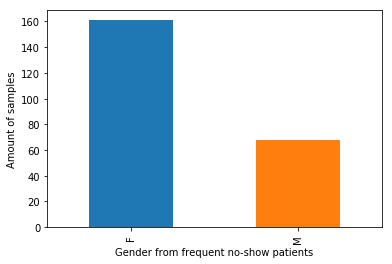

In [219]:
ax = freq_patients[freq_patients['no-show'] == 'Yes'].groupby('gender').size().plot(kind='bar',stacked=True); 
ax.set_xlabel('Gender from frequent no-show patients')
ax.set_ylabel('Amount of samples');

We can observe that many of no-show frequent patients are Women

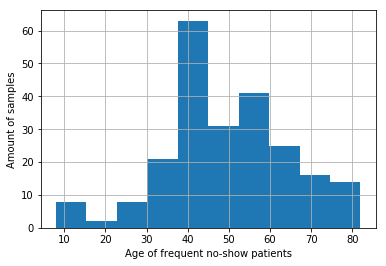

In [221]:
# Let's take a look to their age
ax = freq_patients[freq_patients['no-show'] == 'Yes'].age.hist();
ax.set_xlabel('Age of frequent no-show patients')
ax.set_ylabel('Amount of samples');

We can observe that there are patients between 40-60 age who no-show frequently.

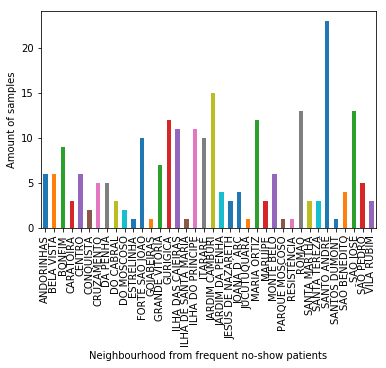

In [222]:
ax = freq_patients[freq_patients['no-show'] == 'Yes'].groupby('neighbourhood').size().plot(kind='bar',stacked=True); 
ax.set_xlabel('Neighbourhood from frequent no-show patients')
ax.set_ylabel('Amount of samples');

We can observe that many of the no-show frequent patients who no-show have appointments to SANTO ANDRE and JARDIM CAMBORI neighbourhoods

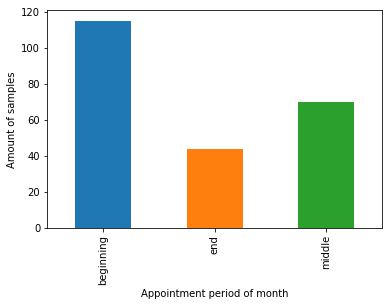

In [224]:
ax = freq_patients[freq_patients['no-show'] == 'Yes'].groupby('appointment_period_of_month').size().plot(kind='bar',stacked=True); 
ax.set_xlabel('Appointment period of month')
ax.set_ylabel('Amount of samples');

We can observe that most of the no-show frequent patients have appointments to the beginning of the month

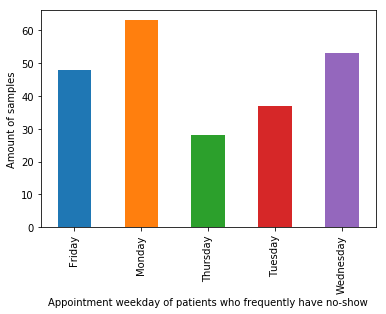

In [229]:
ax = freq_patients[freq_patients['no-show'] == 'Yes'].groupby('appointment_weekday').size().plot(kind='bar',stacked=True); 
ax.set_xlabel('Appointment weekday of patients who frequently have no-show')
ax.set_ylabel('Amount of samples');

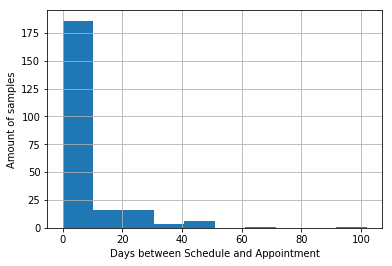

In [227]:
ax = freq_patients[freq_patients['no-show'] == 'Yes'].days_between_sched_appoint.hist();
ax.set_xlabel('Days between Schedule and Appointment')
ax.set_ylabel('Amount of samples');

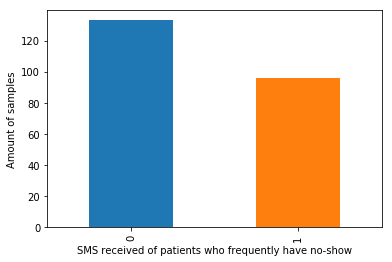

In [231]:
ax = freq_patients[freq_patients['no-show'] == 'Yes'].groupby('sms_received').size().plot(kind='bar',stacked=True); 
ax.set_xlabel('SMS received of patients who frequently have no-show')
ax.set_ylabel('Amount of samples');

# General Question Answer

## Which characteristics determine that a patient will not appear?,

By the answer of the previous intermediate questions, we got some information that could give some clue that a patient will not show up.

1. When the appointments are for Babies, Children or Teenagers, the frequency of no-show is greather than it is for Adults or 
Agededs.
2. Patients who receives scholarship have a slightly bigger no show frequency than those dont receive
3. It was detected that when the interval of days between schedule and appoint is greather than 10 days, the number of no-shows tends to increase.
